In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
up = Path("..")
artefacts = up / up / up / "artefacts"

In [3]:
def mkdf(model: str) -> pd.DataFrame:
    # Load all metadata files
    files = (artefacts / "baselines" / model / "train").glob("apps_id_*/metadata.json")
    data = []
    for f in files:
        with open(f) as fp:
            metadata = json.load(fp)
            idx = f.parent.name.split("_")[-1]
            metadata["apps_id"] = idx
        data.append(metadata)
    
    df = pd.DataFrame(data).set_index("apps_id")
    
    # repair
    theorem_proven_cols = [col for col in df.columns if col.endswith('_proven') and col.startswith('theorem_')]
    df['theorems_proven'] = df[theorem_proven_cols].sum(axis=1)
    # Create the new column by counting non-NA values across theorem attempt columns
    return df

def nonzero_solns(df: pd.DataFrame) -> pd.DataFrame:
    return df[df.theorems_proven > 0]

In [4]:
sonnet = mkdf("sonnet")
sonnet_wins = nonzero_solns(sonnet)

gemini = mkdf("gemini")
gemini_wins = nonzero_solns(gemini)

dfs = [("Sonnet", sonnet), ("Gemini", gemini)]
dfs_wins = [("Sonnet", sonnet_wins), ("Gemini", gemini_wins)]

In [12]:
print(sonnet_wins.shape, gemini_wins.shape)

(60, 32) (43, 32)


In [13]:
gemini.all_defs_proven.sum(), gemini.shape

(np.int64(78), (101, 32))

In [14]:
gemini.total_theorems.value_counts()

total_theorems
4     31
3     23
5     20
6      7
0      6
2      6
7      4
1      1
9      1
8      1
13     1
Name: count, dtype: int64

# Quantitative visualization

## Note: generate some manner of plot describing how many attempts it took things that eventually succeeded. 

In [15]:
sonnet_wins.index

Index(['4742', '0348', '4430', '4172', '3819', '0954', '2671', '0282', '2997',
       '3877', '3057', '0838', '1962', '3040', '1596', '3402', '0314', '1804',
       '3192', '0917', '0375', '1265', '2667', '0716', '1850', '0828', '2459',
       '1710', '4412', '4017', '0986', '1700', '0930', '0323', '4036', '0077',
       '4802', '3199', '3224', '0666', '4045', '1306', '2342', '2654', '3078',
       '2649', '2571', '4338', '1233', '2109', '3311', '3430', '4002', '0069',
       '1732', '2052', '0669', '0267', '1318', '4350'],
      dtype='object', name='apps_id')

# Discussion of Samples with Solved Nonzero Theorems (Sonnet)

- technically nonspurious but solved the easy case of an if: 0282, 3430, 4430, 4172, 3057(0), 3040, 0375(0), 1265, 3430, 2052, 0267(0), 1318(1)
- substituted definition with effectively a unit test and really only proved one case: 1804, 2459, 1233, 0666, 1732, 0267(1)
- `apply Nat.zero_le` loophole: 2459, 1233, 4742, 0375(1), 1850, 4036, 0077, 0069, 0669, 1318(0)
- too trivial: 3819, 3192, 2667, 1306(0), 1306(1), 2649, 2109, 4002, 4350
- actually nontrivial: 3057(1), 3402, 0314, 1710, 4412, 0323, 4045, 2342, 3078
- bug: 2459, 4017, 0930, 4802, 3199(0), 3199(1),

In [16]:
sonnet_solns_types = {
    'easy_branch_of_if': ['0282', '3430', '4430', '4172', '3057(0)', '3040', '0375(0)', '1265', '3430', '2052', '0267(0)', '1318(1)'],
    'effectively_unit_test': ['1804', '2459', '1233', '0666', '1732', '0267(1)'],
    'apply_nat_zero_le': ['2459', '1233', '4742', '0375(1)', '1850', '4036', '0077', '0069', '0669', '1318(0)'],
    'too_trivial': ['3819', '3192', '2667', '1306(0)', '1306(1)', '2649', '2109', '4002', '4350'],
    'actually_nontrivial': ['3057(1)', '3402', '0314', '1710', '4412', '0323', '4045', '2342', '3078'],
    'bug': ['2459', '4017', '0930', '4802', '3199(0)', '3199(1)'],
    "model_declares_untrue": []
}

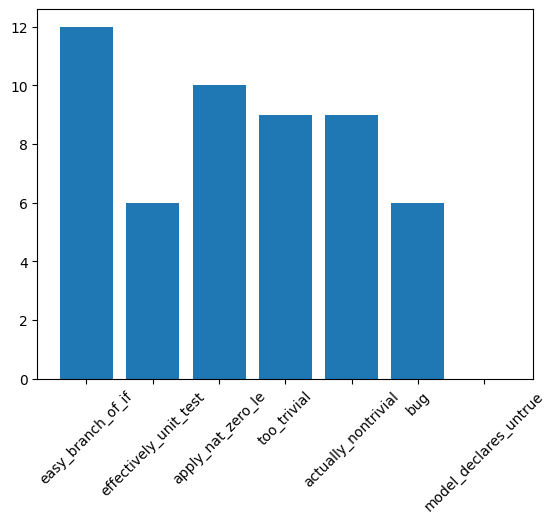

In [17]:
plt.bar(sonnet_solns_types.keys(), [len(v) for v in sonnet_solns_types.values()])
plt.xticks(rotation=45);

# Discussion of Samples with Solved Nonzero Theorems (Gemini)

- technically nonspurious but solved the easy case of an if: 4430, 3040, 0375, 3199, 3430, 0267(0), 1318
- substituted definition with effectively a unit test and really only proved one case: 0267
- `apply Nat.zero_le` loophole: 0077
- too trivial: 3151, 3819, 4017, 0986(0), 0986(1), 4045, 2649, 2112, 2109, 4350
- actually nontrivial: 3057, 3402, 1947(0), 3078(0), 2052
- bug: 1947(1), 4466(model says "it's extremely difficult to reason")
- model declares statement untrue: 3078(1)

In [18]:
gemini_wins.index

Index(['4742', '0348', '4430', '3151', '4172', '3819', '0954', '3057', '1962',
       '3040', '3402', '3192', '0917', '3425', '0375', '2667', '1710', '4412',
       '4017', '0986', '4036', '1947', '0077', '4802', '3199', '4045', '1306',
       '3078', '2649', '2571', '4338', '2112', '2109', '4466', '0895', '3430',
       '4002', '0069', '1732', '2052', '0267', '1318', '4350'],
      dtype='object', name='apps_id')

In [19]:
gemini_solns_types = {
    'easy_branch_of_if': ['4430', '3040', '0375', '3199', '3430', '0267(0)', '1318'],
    'effectively_unit_test': ['0267'],
    'apply_nat_zero_le': ['0077'],
    'too_trivial': ['3151', '3819', '4017', '0986(0)', '0986(1)', '4045', '2649', '2112', '2109', '4350'],
    'actually_nontrivial': ['3057', '3402', '1947(0)', '3078(0)', '2052'],
    'bug': ['1947(1)', '4466'],
    'model_declares_untrue': ['3078(1)']
}

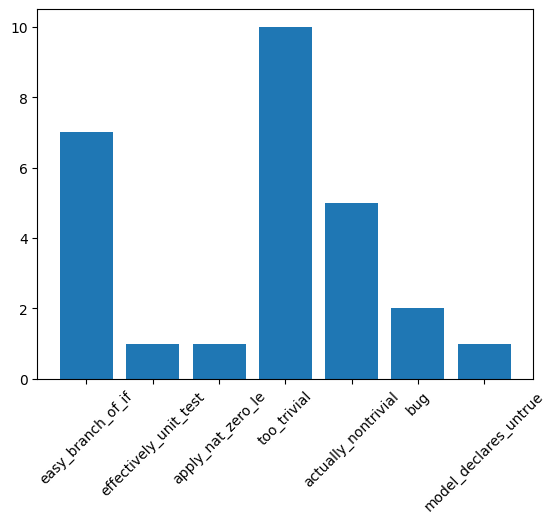

In [20]:
plt.bar(gemini_solns_types.keys(), [len(v) for v in gemini_solns_types.values()])
plt.xticks(rotation=45);

# Types of Solutions (qualitative)

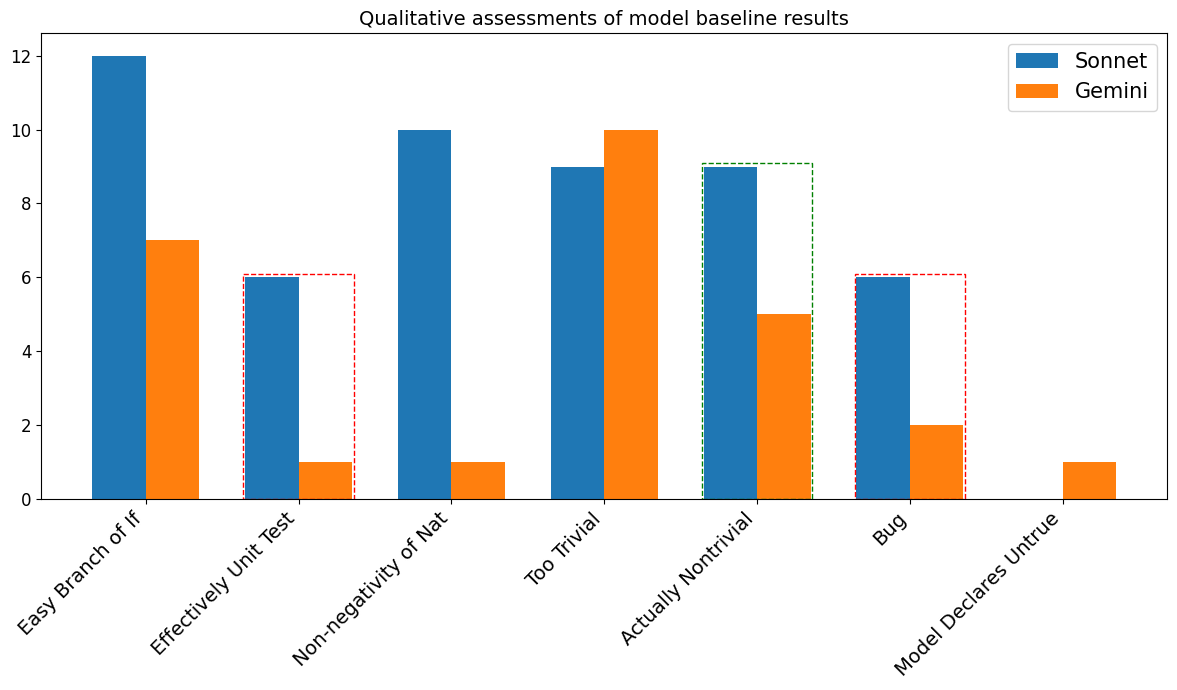

In [21]:
plt.figure(figsize=(12, 7))

x = np.arange(len(sonnet_solns_types))
width = 0.35

plt.bar(x - width/2, [len(v) for v in sonnet_solns_types.values()], width, label='Sonnet')
plt.bar(x + width/2, [len(v) for v in gemini_solns_types.values()], width, label='Gemini')

# Green box around "actually_nontrivial"
green_cat = "actually_nontrivial"
idx = list(sonnet_solns_types.keys()).index(green_cat)
sonnet_height = len(sonnet_solns_types[green_cat])
gemini_height = len(gemini_solns_types[green_cat])
max_height = max(sonnet_height, gemini_height)
rect = plt.Rectangle((idx - width - 1e-2, 0), 2 * (width + 1e-2), max_height + 1e-1, fill=False, color='green', linestyle='--')
plt.gca().add_patch(rect)

for red_cat in ["effectively_unit_test", "bug"]:
    idx = list(sonnet_solns_types.keys()).index(red_cat)
    sonnet_height = len(sonnet_solns_types[red_cat])
    gemini_height = len(gemini_solns_types[red_cat])
    max_height = max(sonnet_height, gemini_height)
    rect = plt.Rectangle((idx - width - 1e-2, 0), 2 * (width + 1e-2), max_height + 1e-1, fill=False, color='red', linestyle='--')
    plt.gca().add_patch(rect)

solns_types_labels = {
    'easy_branch_of_if': 'Easy Branch of If',
    'effectively_unit_test': 'Effectively Unit Test',
    'apply_nat_zero_le': 'Non-negativity of Nat',
    'too_trivial': 'Too Trivial',
    'actually_nontrivial': 'Actually Nontrivial',
    'bug': 'Bug',
    'model_declares_untrue': 'Model Declares Untrue'
}
plt.xticks(x, [solns_types_labels[cat] for cat in sonnet_solns_types.keys()], rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.title("Qualitative assessments of model baseline results", fontsize=14)
plt.tight_layout()
plt.savefig("qualitative_assessment_of_model_baseline_results.png")

In [22]:
gemini.defs_attempts

apps_id
1802    50
1049     3
4742     8
0348     3
4430     5
        ..
2052    16
0669    50
0267     1
1318     1
4350     1
Name: defs_attempts, Length: 101, dtype: int64

# Defs Attempts Viz

Text(0.5, 1.0, 'Number of attempts it took to solve definitions')

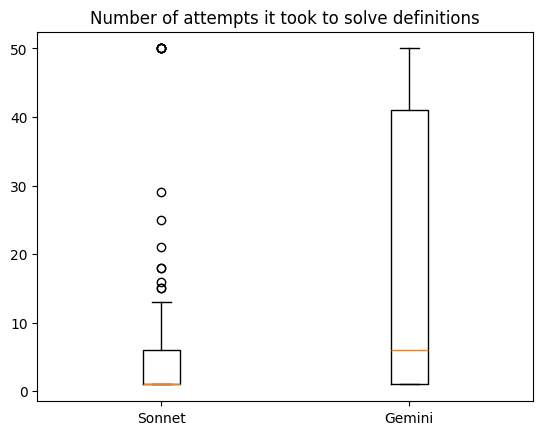

In [23]:
plt.boxplot([sonnet.defs_attempts, gemini.defs_attempts], tick_labels=["Sonnet", "Gemini"])
plt.title("Number of attempts it took to solve definitions")

one shot Sonnet 0.504950495049505
one shot Gemini 0.3069306930693069


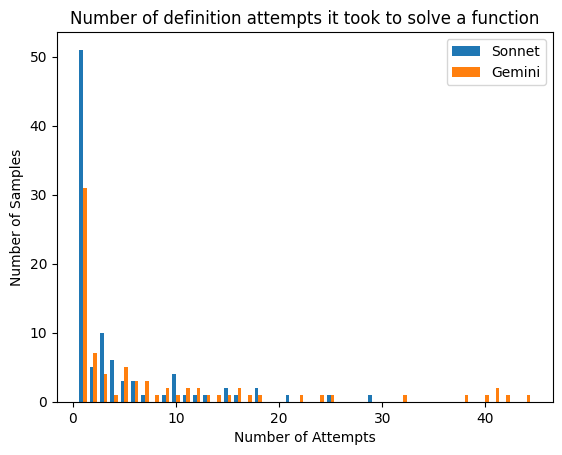

In [24]:
def plot_attempts_comparison(data: list[tuple[str, pd.DataFrame]], title: str, width: float = 0.35, save: bool = False):
    # Get all unique values across all dataframes
    all_values = set()
    for _, df in data:
        all_values.update(df[df.defs_attempts != 50].defs_attempts.unique())
    all_values = np.array(sorted(all_values))
    
    # Plot bars for each dataset
    for i, (label, df) in enumerate(data):
        offset = width * (i - (len(data)-1)/2)
        counts = df.defs_attempts.value_counts().sort_index().reindex(all_values, fill_value=0)
        print("one shot", label, df[df.defs_attempts == 1].shape[0] / df.shape[0])
        plt.bar(all_values + offset, counts, width, label=label)
    
    plt.xlabel('Number of Attempts')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.legend()
    if save: 
        plt.savefig(f"{title.lower().replace(' ', '_')}")

plot_attempts_comparison(dfs, title="Number of definition attempts it took to solve a function", save=True)

one shot Sonnet 0.6333333333333333
one shot Gemini 0.5348837209302325


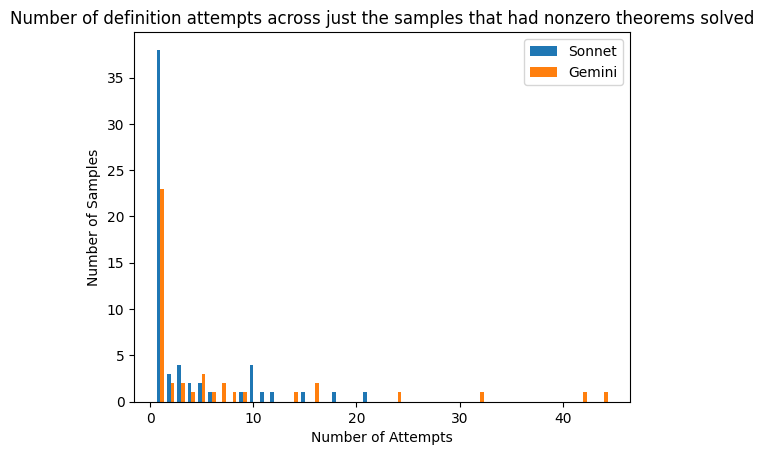

In [25]:
plot_attempts_comparison(dfs_wins, title="Number of definition attempts across just the samples that had nonzero theorems solved")

<Axes: >

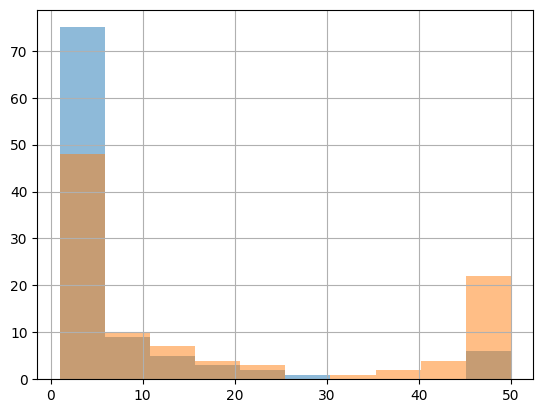

In [26]:
sonnet.defs_attempts.hist(alpha=1/2)
gemini.defs_attempts.hist(alpha=1/2)

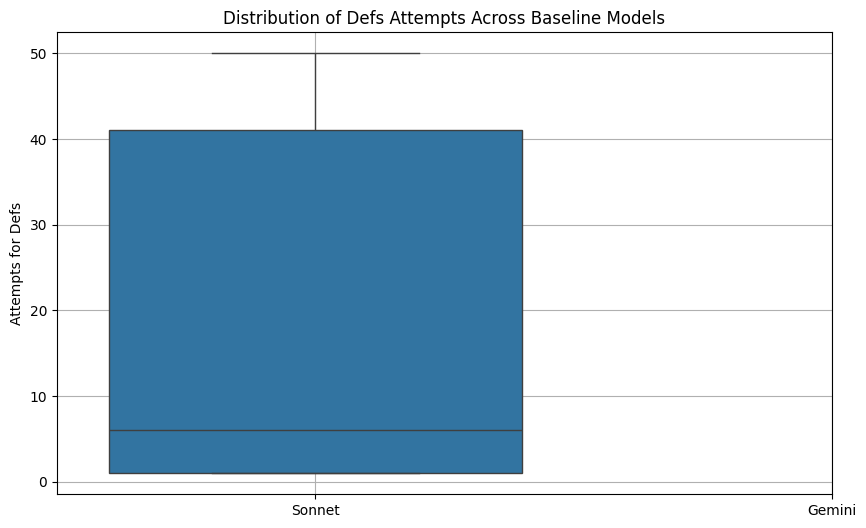

In [27]:
# Assuming your dataframes are df1, df2, df3
# Create box plots side by side
plt.figure(figsize=(10, 6))
sns.boxplot(data=[sonnet.defs_attempts, gemini.defs_attempts])#, df3['defs_attempts']])
plt.xticks([0, 1], ['Sonnet', 'Gemini']) # "4o"])
plt.title('Distribution of Defs Attempts Across Baseline Models')
plt.ylabel('Attempts for Defs')
plt.grid(True)

# Theorem Totals Viz

In [28]:
def ___aggregate_theorem_stats(dfs):
    def process_df(df):
        total_attempts = df[[col for col in df.columns if 'attempts' in col]].sum(axis=1)
        total_proven = df[[col for col in df.columns if 'proven' in col]].sum(axis=1)
        return pd.DataFrame({
            'total_attempts': total_attempts,
            'total_proven': total_proven
        })
    
    return pd.concat([process_df(df) for df in dfs])

In [29]:
___aggregate_theorem_stats([sonnet, gemini])

,total_attempts,total_proven
apps_id,,
1802,3.0,1
1049,78.0,1
4742,128.0,5
0348,102.0,3
4430,75.0,5
...,...,...
2052,116.0,3
0669,50.0,0
0267,213.0,13


In [30]:
def aggregate_theorem_stats(df):
    results = []
    for theorem in range(13):
        attempts = df[f'theorem_{theorem}_attempts']
        proven = df[f'theorem_{theorem}_proven']
        results.append(pd.DataFrame({
            'theorem': theorem,
            'attempts': attempts,
            'proven': proven
        }))
    
    return pd.concat(results).dropna()

aggregate_theorem_stats(gemini)

,theorem,attempts,proven
apps_id,,,
1049,0,25.0,False
4742,0,25.0,False
0348,0,25.0,False
4430,0,25.0,False
3151,0,13.0,True
...,...,...,...
0267,8,25.0,False
0267,9,6.0,True
0267,10,25.0,False


In [31]:
def plot_theorem_attempts_bars(data: list[tuple[str, pd.DataFrame]], title:str, width: float = 0.35, save: bool = False):
    # Get all unique attempt values across all dataframes
    all_values = set()
    for _, df in data:
        stats = aggregate_theorem_stats(df)
        all_values.update(stats[stats.attempts != 25].attempts.unique())
    all_values = np.array(sorted(all_values))
    
    # Plot bars for each dataset
    for i, (label, df) in enumerate(data):
        offset = width * (i - (len(data)-1)/2)
        counts = aggregate_theorem_stats(df).attempts.value_counts().sort_index().reindex(all_values, fill_value=0)
        plt.bar(all_values + offset, counts, width, label=label)
    
    plt.xlabel('Number of Theorem Attempts')
    plt.ylabel('Number of Samples') 
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig(title.lower().replace(" ", "_"))

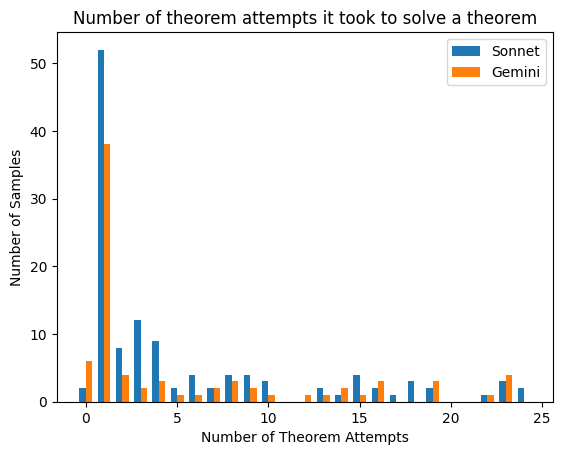

In [32]:
plot_theorem_attempts_bars(dfs_wins, title="Number of theorem attempts it took to solve a theorem", save=True)

In [33]:
for label, df in dfs_wins:
    df_agg = aggregate_theorem_stats(df)
    total = df_agg.shape[0]
    df_agg = df_agg[df_agg.attempts <= 1.0]
    print(label, df_agg.shape[0] / total)

Sonnet 0.19708029197080293
Gemini 0.21568627450980393


# Percentage

In [34]:
sonnet.theorems_proven.sum() / sonnet.total_theorems.sum() # / sonnet.shape[0]

np.float64(0.29802955665024633)

In [35]:
gemini.theorems_proven.sum() / gemini.total_theorems.sum() 

np.float64(0.18226600985221675)

In [36]:
sonnet.total_theorems.sum(), gemini.total_theorems.sum()

(np.int64(406), np.int64(406))

In [37]:
sonnet.theorems_proven.sum(), gemini.theorems_proven.sum()

(121, 74)

In [38]:
sonnet[sonnet.theorems_proven > 0].shape[0], gemini[gemini.theorems_proven > 0].shape[0]

(60, 43)

In [39]:
for (label, df), (label_win, df_win) in zip(dfs, dfs_wins): 
    print(label, df.shape[0] - df_win.shape[0])

Sonnet 41
Gemini 58


# Categorizing baseline results against QA process

In [14]:
import datasets
fvapps_df = pd.DataFrame(datasets.load_dataset("quinn-dougherty/fvapps", split="train"))
fvapps_df.head()

,apps_id,apps_question,spec,units,sorries,apps_difficulty,assurance_level
0,0000,Polycarp has $n$ different binary words. A wor...,def solve (n : Nat) (words : List String) : Li...,"/--\ninfo: [1, 3]\n-/\n#guard_msgs in\n#eval s...",4,interview,unguarded
1,0001,Mikhail walks on a Cartesian plane. He starts ...,def solve_max_diagonal_moves (n m k : Int) : I...,/--\ninfo: 1\n-/\n#guard_msgs in\n#eval solve_...,5,interview,guarded_and_plausible
2,0002,"You are given three sequences: $a_1, a_2, \ldo...",def solve_sequence (n : Nat) (a b c : List Nat...,/--\ninfo: n3\n-/\n#guard_msgs in\n#eval len s...,3,interview,unguarded
3,0003,"You have $n$ barrels lined up in a row, number...",/-- Function signature for max_water_differenc...,/--\ninfo: 10\n-/\n#guard_msgs in\n#eval max_w...,6,interview,guarded
4,0004,"You are given a permutation $p=[p_1, p_2, \ldo...",def solve_beautiful_permutation (nums : List N...,/--\ninfo: '101011'\n-/\n#guard_msgs in\n#eval...,4,interview,unguarded


In [15]:
sonnet_wins.index

Index(['4742', '0348', '4430', '4172', '3819', '0954', '2671', '0282', '2997',
       '3877', '3057', '0838', '1962', '3040', '1596', '3402', '0314', '1804',
       '3192', '0917', '0375', '1265', '2667', '0716', '1850', '0828', '2459',
       '1710', '4412', '4017', '0986', '1700', '0930', '0323', '4036', '0077',
       '4802', '3199', '3224', '0666', '4045', '1306', '2342', '2654', '3078',
       '2649', '2571', '4338', '1233', '2109', '3311', '3430', '4002', '0069',
       '1732', '2052', '0669', '0267', '1318', '4350'],
      dtype='object', name='apps_id')

In [16]:
gemini_wins.index

Index(['4742', '0348', '4430', '3151', '4172', '3819', '0954', '3057', '1962',
       '3040', '3402', '3192', '0917', '3425', '0375', '2667', '1710', '4412',
       '4017', '0986', '4036', '1947', '0077', '4802', '3199', '4045', '1306',
       '3078', '2649', '2571', '4338', '2112', '2109', '4466', '0895', '3430',
       '4002', '0069', '1732', '2052', '0267', '1318', '4350'],
      dtype='object', name='apps_id')

In [18]:
assurance_map = fvapps_df.set_index("apps_id")["assurance_level"].to_dict()

sonnet_wins["assurance_level"] = sonnet_wins.index.map(assurance_map)
gemini_wins["assurance_level"] = gemini_wins.index.map(assurance_map)

/tmp/ipykernel_409649/40212814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sonnet_wins["assurance_level"] = sonnet_wins.index.map(assurance_map)
/tmp/ipykernel_409649/40212814.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemini_wins["assurance_level"] = gemini_wins.index.map(assurance_map)


In [21]:
sonnet_wins.assurance_level.value_counts()

assurance_level
unguarded                41
guarded_and_plausible    12
guarded                   7
Name: count, dtype: int64

In [22]:
gemini_wins.assurance_level.value_counts()

assurance_level
unguarded                28
guarded_and_plausible    11
guarded                   4
Name: count, dtype: int64

In [23]:
sonnet["assurance_level"] = sonnet.index.map(assurance_map)
gemini["assurance_level"] = gemini.index.map(assurance_map)

In [24]:
sonnet.assurance_level.value_counts()

assurance_level
unguarded                69
guarded_and_plausible    18
guarded                  14
Name: count, dtype: int64

In [25]:
gemini.assurance_level.value_counts()

assurance_level
unguarded                69
guarded_and_plausible    18
guarded                  14
Name: count, dtype: int64

# Specific Results (code samples)

## 0282

`Theorem_1_final.lean`:

```lean
/-- Calculate floor of sqrt of Int n using binary search -/
def floorSqrt (n: Int) : Int := Id.run do
  if n ≤ 0 then return 0
  let mut left := 1 
  let mut right := n
  let mut ans := 0
  while left ≤ right do
    let mid := left + (right - left) / 2
    if mid * mid ≤ n then
      ans := mid 
      left := mid + 1
    else
      right := mid - 1
  ans

/-- Get minimum element in list, returns 0 for empty list -/
def minElem (list: List Int) : Int :=
  match list with
  | [] => 0
  | x::xs => List.foldl min x xs

/-- Sum elements in list using foldl -/
def sumList (list: List Int) : Int :=
  List.foldl (· + ·) 0 list

/-- Alias for sumList -/
def listSum (list: List Int) : Int := sumList list

/-- Helper function to sum elements in square submatrix -/
def sumSquare (mat : List (List Int)) (i j size : Nat) : Int :=
  let square := List.take size $ List.drop i mat
  let rows := square.map (λ row => List.take size $ List.drop j row)
  sumList $ List.join rows

/-- Get the maximum side length of square submatrix with sum <= threshold -/
def maxSideLength (mat: List (List Int)) (threshold: Int) : Int := 
  match mat with
  | [] => 0
  | head::tail => 
    let m := tail.length + 1 -- rows
    let n := head.length -- cols
    if threshold < minElem (List.map minElem (head::tail)) then 0
    else
      -- Binary search implementation
      Id.run do
        let mut left := 1
        let mut right := min m n
        let mut ans := 0      
        while left ≤ right do
          let side := left + (right - left) / 2
          let mut found := false
          for i in [0:m - side + 1] do
            for j in [0:n - side + 1] do
              let mut squareSum := 0
              for r in [i:i+side] do
                squareSum := squareSum + (listSum $ List.take side $ List.drop j (mat[r]!))        
              if squareSum ≤ threshold then found := true
          if found then
            ans := side
            left := side + 1 
          else
            right := side - 1
        Int.ofNat ans

theorem minElem_cons_eq_minElem_map {x : List Int} {xs : List (List Int)} :
  minElem (List.map minElem (x::xs)) = minElem (minElem x :: List.map minElem xs) := by
  simp [List.map]

/-- If threshold is less than minimum element in matrix, max side length must be 0 -/
theorem maxSideLength_low_threshold {mat : List (List Int)} {threshold : Int}
  (h1 : ∀ row ∈ mat, row.length = (List.head! mat).length) 
  (h2 : threshold < minElem (List.map minEl em mat)) :
  maxSideLength mat threshold = 0 := by
  unfold maxSideLength
  cases mat with
  | nil => rfl 
  | cons head tail => 
    simp [minElem_cons_eq_minElem_map] at h2
    simp [h2]
```

### _discussion_

The theorem that succeeded was the easy case

## 3430

`Theorem_0_final.lean`:
```lean
def lowest_temp (s : String) : Option Int := 
  -- If string is empty, return none
  if s.isEmpty then none
  else
    -- Split string by spaces and convert to array of ints
    let temps := s.split (· = ' ') |>.toArray
    if temps.isEmpty then none 
    else
      -- Start with first number as minimum
      let first := temps[0]!.toInt!
      -- Fold over remaining numbers to find minimum 
      some (temps.foldl (init := first) fun acc str =>  
        let curr := str.toInt!
        if curr < acc then curr else acc)

theorem lowest_temp_empty: lowest_temp "" = none := by
  -- Unfold definition of lowest_temp 
  unfold lowest_temp
  -- Since "" is empty, the isEmpty check returns true
  simp [String.isEmpty]
  -- For empty string, need to show endPos ≠ 0 implies split returns []
  intro h
  -- Empty string has endPos = utf8ByteSize = 0
  have : "".utf8ByteSize = 0 := rfl
  -- This contradicts our assumption h
  contradiction
```

### _discussion_

Same as above- the theorem that succeeded was the trivial case.

# `3402` theorem code